In [6]:
import os, json
from Tint_Matlab import *
import struct
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import SignalProcessing as sp
%matplotlib inline
import re
%load_ext line_profiler
import profile
import time
import mmap
import contextlib
import numpy.distutils.system_info as sysinfo

In [7]:
#bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
# bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
bin_filename = "C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"
bin_filename = 'E:\\Apollo_D_Drive\\ApolloKlusta\\Processed\\Raw30Min - Copy\\20170927-RAW-30MIN.bin'
bin_filename = 'E:\\Apollo_D_Drive\\ApolloKlusta\\ANT 202a3\\20171024-7-LargeBox-1400um-GAR.bin'
#bin_filename = "C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"

bin_directory = os.path.dirname(bin_filename)
session = os.path.basename(os.path.splitext(bin_filename)[0])
set_filename = os.path.join(bin_directory, '%s.set' % session)
pos_filename = os.path.join(bin_directory, '%s.pos' % session)

In [8]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""
    
    
    if channels == []:
        channels = np.arange(64)+1
    else:
        channels = np.asarray(channels)
    
    A = np.asarray(A)
    
    sample_num = int(len(A)/64) # get the sample numbers
    
    sample_array = np.zeros((len(channels),sample_num)) # creating a 64x3 array of zeros (64 channels, 3 samples)
    
    '''
    for i in range(3):
        # there are three samples
        
        current_sample = A[:64] # defines current samples
        
        for k in range(64):
            
            sample_array[k,i] = current_sample[get_remap_chan(k+1)]
        
        A = A[64:]  # discards the used samples
    '''
    
    for i, channel in enumerate(channels):
        sample_array[i,:] = A[get_sample_indices(channel, sample_num)]
            
    return sample_array

def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)
    

def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""
    
    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 
                      6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11, 
                      12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17, 
                      18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63, 
                      24, 25, 26, 27, 28, 29, 30, 31])
    
    return remap_channels[chan_num-1]
            
            
def find_sub(string, sub):
    '''finds all instances of a substring within a string and outputs a list of indices'''
    result = []
    k = 0
    while k < len(string):
        k = string.find(sub, k)
        if k == -1:
            return result
        else:
            result.append(k)
            k += 1  # change to k += len(sub) to not search overlapping results
    return result


def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if 
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'
    
    with open(set_filename) as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_')+1:])
                    active_tetrode.append(tet_number)
                    
    return active_tetrode

def get_active_eeg(set_filename):
    """This will return a dictionary (cative_eeg_dict) where the keys 
    will be eeg channels from 1->64 which will represent the eeg suffixes (2 = .eeg2, 3 = 2.eeg3, etc)
    and the key will be the channel that the EEG maps to (a channel from 0->63)"""
    active_eeg = []
    active_eeg_str = 'saveEEG_ch'
    
    eeg_map = []
    eeg_map_str = 'EEG_ch_'
    
    active_eeg_dict = {}
    
    with open(set_filename) as f:
        for line in f:
            
            if active_eeg_str in line:
                 # saveEEG_ch_X Y, where x is the eeg number, and Y is eitehr on or off (1 or 0)
                _, status = line.split(' ')
                active_eeg.append(int(status))
            elif eeg_map_str in line:
                #EEG_ch_X Y
                _, chan = line.split(' ')
                eeg_map.append(int(chan))
                
                
        # active_eeg = np.asarray(active_eeg)
        # eeg_map = np.asarray(eeg_map)
    
    for i, status in enumerate(active_eeg):
        if status == 1:
            active_eeg_dict[i+1] = eeg_map[i] - 1
        
    return active_eeg_dict


def is_egf_active(set_filename):
    
    active_egf_str = 'saveEGF'
    
    with open(set_filename) as f:
        for line in f:
            
            if active_egf_str in line:
                _, egf_status = line.split(' ')
                
                if int(egf_status) == 1:
                    return True
                
        return False

    
def get_Fs(set_filename):
    
    fs_str = 'rawRate'
    
    with open(set_filename) as f:
        for line in f:
            
            if fs_str in line:
                _, Fs = line.split(' ')
                
                try:
                    return int(Fs)
                except:
                    return float(Fs)
    return []
   
    
def create_eeg(filename, data, Fs):
    # data is given in int16, and already has been notch filtered
    
    if os.path.exists(filename):
        return
    
    Fs_EEG = 250  # sampling rate of .EEG files
    
    data = sp.Filtering().iirfilt(bandtype='low', data=data, Fs=Fs, Wp=Fs_EEG / 2, order=6, 
                                  automatic=0, Rp=3, As=60, filttype='butter', showresponse=0)
    
    ##################################################################################################
    # ---------------------------Downsample to produce the proper EEG------------------------
    ##################################################################################################
    
    data = data[:, 0::int(Fs / Fs_EEG)]
    
    # ensuring the appropriate range of the values
    data[np.where(data > 32767)] = 32767
    data[np.where(data < -32768)] = -32768
    
    data = int16toint8(data) # converting from 16 bits to 8 bits, 
    
    # ensurinig appropriate range of values (this shouldn't be necessary)
    data[np.where(data > 127)] = 127
    data[np.data(data < -128)] = -128
    
    ##################################################################################################
    # ---------------------------Writing the EEG Data-------------------------------------------
    ##################################################################################################
    
    write_eeg(filename, data, Fs_EEG)
    
def create_egf(filename, data, Fs):
    
    if os.path.exists(filename):
        return
    
    Fs_EGF = 4.8e3  # sampling rate of .EGF files
    
    data = sp.Filtering().iirfilt(bandtype='low', data=data, Fs=Fs, Wp=Fs_EGF / 2, order=6, 
                                  automatic=0, Rp=3, As=60, filttype='butter', showresponse=0)
    
    ##################################################################################################
    # ---------------------------Downsample to produce the proper EGF Data------------------------
    ##################################################################################################
    
    data = data[:, 0::int(Fs / Fs_EGF)]
    
    # ensuring the appropriate range of the values
    data[np.where(data > 32767)] = 32767
    data[np.where(data < -32768)] = -32768
    
    # data is already in int16 which is what the final unit should be in
    
    ##################################################################################################
    # ---------------------------Writing the EGF Data-------------------------------------------
    ##################################################################################################
    
    write_eeg(filename, data, Fs_EGF)
    

In [9]:
def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""
    
    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 
                      6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11, 
                      12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17, 
                      18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63, 
                      24, 25, 26, 27, 28, 29, 30, 31])
    
    return remap_channels[chan_num-1]

def get_lfp_bytes(iterations):
    """This function works, but the strategy I use didn't. I was going to slice the bytearray like you would
    a numpy array but that didn't work"""
    data_byte_len = 384
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*432 + 32
    offset_indices = np.tile(offset_indices,(384,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices
    
def get_lfp_indices(iterations):
    data_byte_len = 192
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, iterations))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = offset_indices*213 + 13
    offset_indices = np.tile(offset_indices,(192,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices

    
def find_n(iterations, optimal=1000):
    n = optimal
    
    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

    
def get_channel_bytes(channel_number, samples):
    """This will get the indices of the data if it is just the lfp data (not the bytes header bytes or trailing bytes)"""
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)


def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode) # just in case the user gave a string as the tetrode
    
    return np.arange(1,5) + 4*(tetrode-1)

In [43]:
%%time

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import mmap
import contextlib
#filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\Raw30Min\\20170927-RAW-30MIN.bin'
filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin'
filename = 'E:\\Apollo_D_Drive\\ApolloKlusta\\ANT 202a3\\20171024-7-LargeBox-1400um-GAR.bin'
filename = 'E:\\Apollo_D_Drive\\ApolloKlusta\\ANT 202a1\\20171024-7-LargeBox-1400um-GAR.bin'
# filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\Raw30m\\20170927-RAW-30MIN.bin'
#filename = bin_filename

tetrode = 1
channels = get_channel_from_tetrode(tetrode)
with open(filename, 'rb') as f:
    # pass
    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
        num_iterations = int(len(m)/432)
        
        data = np.ndarray((num_iterations,), (np.int16, (1,192)), m, 32, (432,)).reshape((-1, 1)).flatten()
        data = samples_to_array(data, channels=channels.tolist())
        
#a = a[:]
print(data)

[[ 5586. -9256.  1438. ..., -5992. -4504.  -686.]
 [ 9904.  1732. -2316. ..., -1684. -4438. -5740.]
 [ 4168. -9546.  2592. ..., -9666. -9726. -6518.]
 [ 6880. -7054. -2182. ...,  8246.  6790.  3276.]]
Wall time: 34.4 s


1.0416666666666667


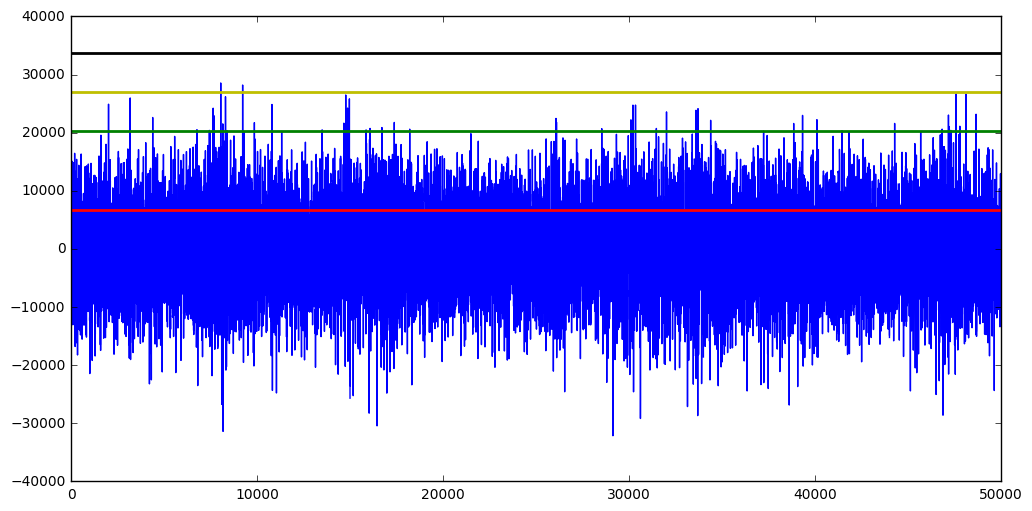

In [49]:
channel_data = data
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 1000
Fs = 48e3
time_value = 60
num_samples = int(Fs*time_value)
num_samples = 10000
print(num_samples/Fs)
sigma_n = np.median(np.abs(channel_data) / 0.6745, axis=1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(channel_data[0,:num_samples])
ax.axhline(sigma_n[0], 0, num_samples, color='r', lw=2)
ax.axhline(3*sigma_n[0], 0, num_samples, color='g', lw=2)
ax.axhline(4*sigma_n[0], 0, num_samples, color='y', lw=2)
ax.axhline(5*sigma_n[0], 0, num_samples, color='k', lw=2)

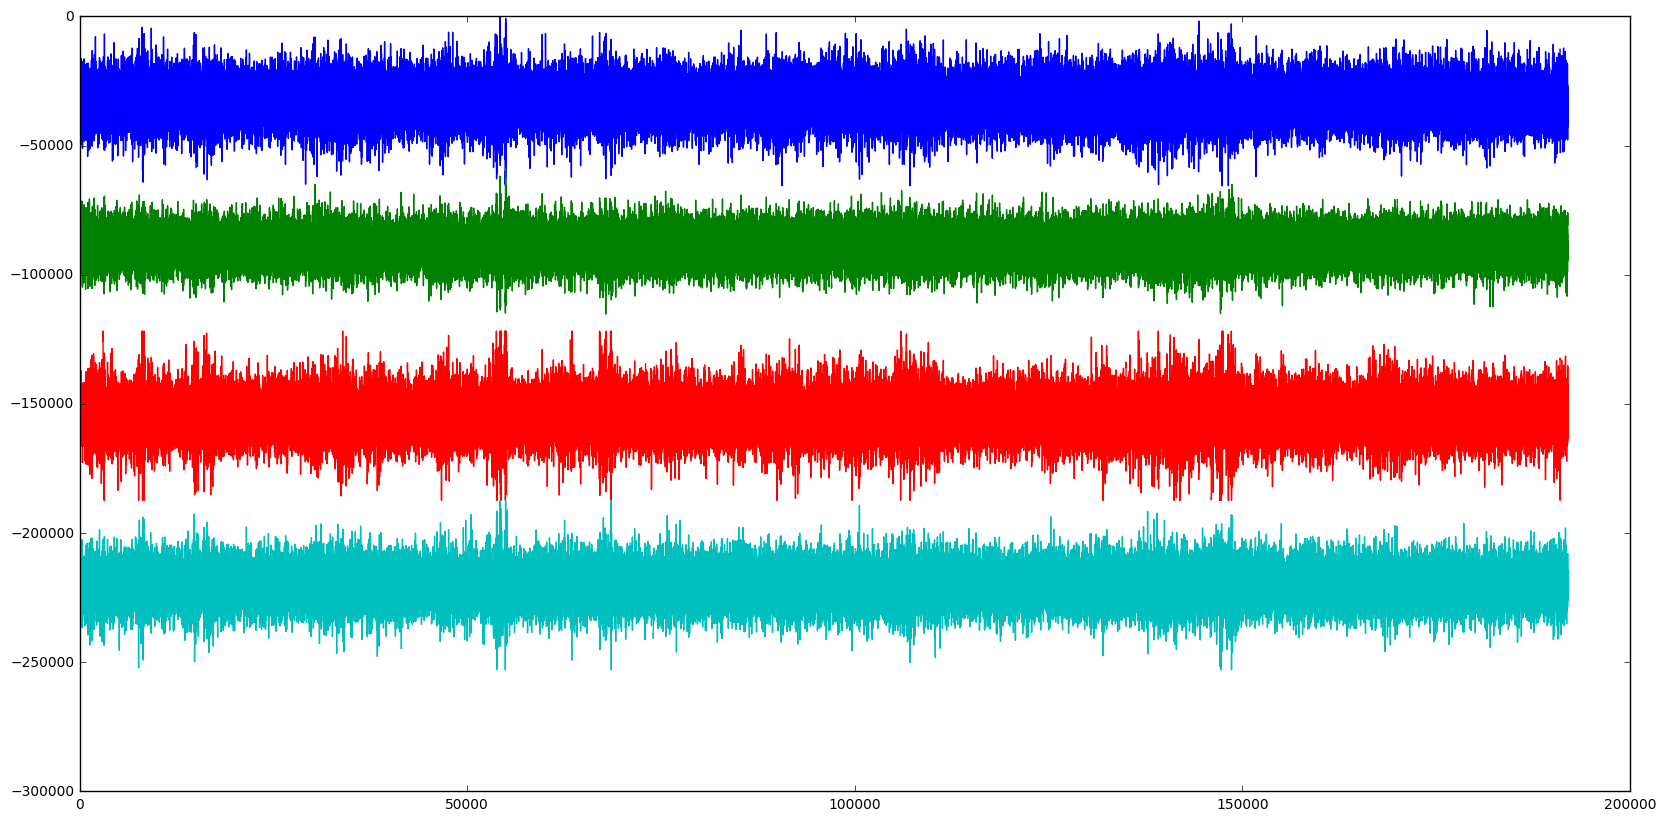

In [45]:
channel_data = data

sigma_n = np.median(np.abs(channel_data) / 0.6745, axis=1)

Fs = 48000
time_value = len(data/Fs)

num_samples = int(Fs*time_value)

indices = np.arange(num_samples)

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
for i, chan_data in enumerate(channel_data):
    chan_data = chan_data[indices]
    if i == 0:
        min_value = np.amin(chan_data)
    else:
        min_value = min_value - (np.amax(chan_data) - np.amin(chan_data))
        
    ax.plot(chan_data + min_value)

In [14]:
%%time
get_bin_data(filename, tetrode=1)

Wall time: 19.2 s


array([[     0.,      0.,      0., ...,  10928.,   8892.,   7286.],
       [     0.,      0.,      0., ...,  11820.,   8468.,   6326.],
       [     0.,      0.,      0., ...,  -1350.,  -3370.,  -4794.],
       [     0.,      0.,      0., ...,    854.,   1198.,   1266.]])

In [11]:
18.5/.844

21.919431279620852

In [15]:
%%time
get_bin_data2(filename, tetrode=1)

Wall time: 822 ms


array([[     0.,      0.,      0., ...,  10928.,   8892.,   7286.],
       [     0.,      0.,      0., ...,  11820.,   8468.,   6326.],
       [     0.,      0.,      0., ...,  -1350.,  -3370.,  -4794.],
       [     0.,      0.,      0., ...,    854.,   1198.,   1266.]])

In [13]:
data1 = get_bin_data(filename, tetrode=1)
data2 = get_bin_data2(filename, tetrode=1)

print('close %s' % str(np.allclose(data1, data2)))

True

In [20]:
data1 = get_bin_data(filename, channels=[2,3])
data2 = get_bin_data2(filename, channels=[2,3])
print('close: %s' % str(np.array_equal(data1, data2)))

close: True


In [7]:
def get_bin_data(bin_filename, channels=None, tetrode=None):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode or channels (from 1-64) that you want to get"""
    # Reading the Data
    bin_directory = os.path.dirname(bin_filename)
    session = os.path.basename(os.path.splitext(bin_filename)[0])
    set_filename = os.path.join(bin_directory, '%s.set' % session)

    # byte_id (4 bytes), packetnumber (4 bytes) = 2i
    # dig in (2), sync in (2) = 2h
    # frame_cnt (4) = i
    # 8 words (2/each), 192 ephys data points (2 each), dig out (2), stim stat(2), 10 bytes of zeros (5x 2 bytes), 2 bytes ascii
    # string = 2i,2h,211i
    iteration_string = '%di%dhi%dh' % (2, 2, 8 + 192 + 1 + 1 + 5 + 1)

    if tetrode is not None:
        channels = get_channel_from_tetrode(tetrode)
    else:
        channels = np.array(channels)  # just in case it isn't an np.array

    byte_count = os.path.getsize(bin_filename)

    bytes_per_iteration = 432

    iteration_count = int(byte_count / bytes_per_iteration)
    total_sample_count = iteration_count * 192  # each iteration has 192 samples (64*3), sample acount including all channels
    channel_sample_count = iteration_count * 3
    # DaqFs = 48000
    # duration = iteration_count * 3 / DaqFs
    # duration = np.ceil(duration)

    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    # read the set file to get the active channel information
    active_tetrodes = get_active_tetrode(set_filename)

    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do

    simul_samples = simul_iterations * 3
    byte_chunksize = int(simul_iterations * bytes_per_iteration)

    with open(bin_filename, 'rb') as f:
        # open the bin file

        channel_data = np.zeros((len(channels), channel_sample_count))

        for i in range(n):
            data = f.read(byte_chunksize)
            data = np.asarray(struct.unpack('<%s' % (simul_iterations * iteration_string), data))
            data = data[get_lfp_indices(simul_iterations)]

            channel_data[:, simul_samples * i:simul_samples * (i + 1)] = samples_to_array(data, 
                                                                                          channels=channels.tolist())

    return channel_data

In [8]:
def get_bin_data2(bin_filename, channels=None, tetrode=None):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode or channels (from 1-64) that you want to get"""

    if tetrode is not None:
        channels = get_channel_from_tetrode(tetrode)
    else:
        channels = np.array(channels)  # just in case it isn't an np.array

    bytes_per_iteration = 432

    with open(bin_filename, 'rb') as f:
        # pass
        with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
            num_iterations = int(len(m)/bytes_per_iteration)

            data = np.ndarray((num_iterations,), (np.int16, (1,192)), m, 32, (bytes_per_iteration,)).reshape((-1, 1)).flatten()
            data = samples_to_array(data, channels=channels.tolist())

    return data